# Finetuning of BERT - Single Label (Veg)
This notebook is an adaptation of the `AFFECT-FINETUNING-BERTino_for_multi_label_text_classification.ipynb` notebook presented in class. 

The purpose is to finetune BERT (`bert-base-cased`) on our dataset, with the aim of doing binary classification over the label `Veg` (column `Vegetarian&Dessert` of the dataset obtained in the notebook Data_Understanding.ipynb).

In [14]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Features, Value, DatasetDict
from tqdm import tqdm

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset Loading
We will use the cleaned dataset obtained in `Data_Understanding.ipynb`.

In [3]:
df = load_dataset('csv', data_files='dataset/dataset.csv')

In [4]:
# see datatype of df
print(type(df))

<class 'datasets.dataset_dict.DatasetDict'>


In [5]:
df.keys()

dict_keys(['train'])

In [6]:
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Dessert': Value(dtype='int64', id=None),
 'Meat': Value(dtype='int64', id=None),
 'Fish': Value(dtype='int64', id=None),
 'Dairy': Value(dtype='int64', id=None),
 'Vegetarian&Dessert': Value(dtype='int64', id=None),
 'Meat&Fish': Value(dtype='int64', id=None)}

## Data Casting
As we can see a few cells above, the first 3 features are already in the wanted data type: `string`. Let's cast the others into `bool` (... and make other adjustments). 

In [7]:
# REMOVE columns Vegetarian, Desert, Dairy, Meat, Fish, Meat&Fish since we will consider Vegetarian&Dessert
df = df.remove_columns(['Vegetarian', 'Dessert', 'Dairy', 'Meat', 'Fish', 'Meat&Fish'])

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Vegetarian&Dessert': Value(dtype='int64', id=None)}

In [8]:
# RENAME columns Vegetarian&Dessert to Veg

def rename_column(example):
    # Rename 'Vegetarian&Dessert' to 'Veg'
    if 'Vegetarian&Dessert' in example:
        example['Veg'] = example.pop('Vegetarian&Dessert')
    return example

# Apply the rename_column function to each example in the dataset
for split in df.keys():
    df[split] = df[split].map(rename_column)

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Veg': Value(dtype='int64', id=None)}

In [9]:
# CAST variables to boolean
df['train'] = df['train'].cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

In [10]:
# Percentage of Veg recipes
sum(df['train']['Veg'])/len(df['train'])*100

32.85228029189746

In [11]:
# drop the recipes with more than 512 tokens
df['train'] = df['train'].filter(lambda x: len(x['cooking_method'].split()) <= 512)

In [12]:
len(df['train'])

78296

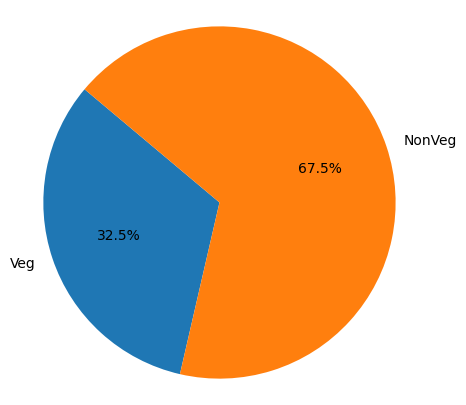

In [13]:
# Count the number of 'Veg' and 'NonVeg' recipes
veg_count = sum(df['train']['Veg'])
non_veg_count = len(df['train']) - veg_count

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie([veg_count, non_veg_count], labels=['Veg', 'NonVeg'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')

# Display the pie chart
plt.show()

## Dataset Balancing
We noticed that data balancing gave better results, so we subsampled our dataset to have the same number of Non-Veg and Veg recipes.

In [15]:
# Order the dataset based on 'Veg' label
df['train'] = df['train'].sort('Veg', reverse=True)

# Count the number of instances with 'Veg' label as True
num_veg = sum(df['train']['Veg'])

# Reduce the df to the first num_veg * 2 instances
df['train'] = df['train'].select(range(num_veg * 2))

# Shuffle the dataset
df['train'] = df['train'].shuffle(seed=seed)

# Check if it's balanced now
print('Percentage of Veg recipes is:', sum(df['train']['Veg'])/len(df['train'])*100, '%')

Percentage of Veg recipes is: 50.0 %


In [16]:
print('Length of the dataset is now:', len(df['train']))

Length of the dataset is now: 50902


## Split
Let's split our dataset stratifying on `Veg`. We keep the 30% of the datasrt for Test, and the remaining 70% is splittet as 80/20 for the Train and Validation.

In [17]:
# column we want to stratify with respect to
stratify_column_name = "Veg"

# create class label column and stratify
df['train'] = df['train'].class_encode_column(stratify_column_name)

Stringifying the column:   0%|          | 0/50902 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/50902 [00:00<?, ? examples/s]

In [19]:
# Notice that now Veg has 'False' and 'True' as class labels
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': ClassLabel(names=['False', 'True'], id=None)}

In [20]:
# split the dataset into train, validation and test stratifying with respect to Veg
df = df['train'].train_test_split(test_size=0.3, seed = seed, stratify_by_column = 'Veg')
train_validation = df['train'].train_test_split(test_size=0.2, seed = seed, stratify_by_column='Veg')

dataset = DatasetDict()
dataset['test'] = df['test']
dataset['train'] = train_validation['train']
dataset['validation'] = train_validation['test']
dataset.shape

{'test': (15271, 9), 'train': (28504, 9), 'validation': (7127, 9)}

In [21]:
# CAST 'Veg' back to boolean for split in dataset.keys()
dataset = dataset.cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

Casting the dataset:   0%|          | 0/15271 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/28504 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7127 [00:00<?, ? examples/s]

Now, let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [23]:
dataset['train'].features.keys()

dict_keys(['cooking_method', 'ingredients', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg'])

In [25]:
labels = [label for label in dataset['train'].features.keys() if label not in ['cooking_method','ingredients', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium']]
labels

['Veg']

In [26]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

id2label, label2id

({0: 'Veg'}, {'Veg': 0})

## Data Preprocessing

In [27]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [28]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["cooking_method"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [29]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/15271 [00:00<?, ? examples/s]

Map:   0%|          | 0/28504 [00:00<?, ? examples/s]

Map:   0%|          | 0/7127 [00:00<?, ? examples/s]

In [30]:
encoded_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

Let's experiment with a recipe to understand the functioning of each step.

In [31]:
i = encoded_dataset['train'][0]['input_ids']
len(i)

512

In [32]:
# let's see how many pads are added
pads = [token for token in i if token == 0]
len(pads)

152

In [33]:
# notice that the last tokens are [PAD] tokens!
tokenizer.decode(i)

"[CLS] ['Preheat the oven to 325 degrees. ','In an oven proof casserole, heat, until very hot, half of the oil. In small batches brown the veal cubes on all sides. When one batch is done, add more oil if you need to and continue to brown until all the veal is done. Discard the fat in the casserole and replace it with the butter. Add the carrot, onion and celery, cover and simmer 5 minutes or until onions are translucent. Add the white wine and boil down for a minute or until alcohol has evaporated. Return the veal cubes to the casserole with garlic and add just enough broth to barely cover the veal. Bring the liquid to a boil, add the bouquet garni, put a buttered piece of parchment or brown paper on top of the meat, then a lid on the casserole and set in the oven. Cook for 1 1 / 4 to 1 1 / 2 hours or until the meat is tender. ','Remove casserole from the oven and strain the contents through a sieve and the liquid into another saucepan ; discard bouquet garni. Divide solids into 2 batc

In [35]:
encoded_dataset['train'][0]['labels']

[0.0]

In [36]:
# This recipe is not Veg therefore we get []
[id2label[idx] for idx, label in enumerate(encoded_dataset['train'][0]['labels']) if label == 1.0]

[]

Now, let's make Train/Val/Test PyTorch datasets.

In [37]:
encoded_dataset.set_format("torch")

In [38]:
type(encoded_dataset)

datasets.dataset_dict.DatasetDict

In [39]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train the model!
We tried different configurations of the hyperparameters; the best one is reported below.

In [ ]:
args = TrainingArguments(
    f"google-bert/bert-base-cased",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    save_steps = 250,
    eval_steps = 250,
    save_total_limit = 2,
    learning_rate = 1e-4,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    weight_decay = 0.05,
    warmup_steps = 2,
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    #push_to_hub = True
)

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

# Evaluation

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model("./models/bert-finetuned-group15")

---
# Testing the finetuned model

In [43]:
# NOTE: run this cell if you don't have the finetuned model in memory and change the path to the location of the model
path = './models/bert-finetuned-veg-group15'
model = AutoModelForSequenceClassification.from_pretrained(path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [90]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score, classification_report


def multi_label_metrics_test(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    precision_micro = precision_score(y_true, y_pred, average='micro')

    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')

    f1_binary = f1_score(y_true=y_true, y_pred=y_pred, average='binary')
    recall_binary = recall_score(y_true, y_pred, average='binary')
    precision_binary = precision_score(y_true, y_pred, average='binary')
    
    print(labels)

    # do a classification report
    class_report = classification_report(y_true, y_pred, target_names=['NonVeg', 'Veg'])
    print(class_report)
    


    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'recall': recall_micro,
               'precision': precision_micro,
               'f1_macro': f1_macro_average,
               'recall_macro': recall_macro,
               'precision_macro': precision_macro,
               'f1_weighted': f1_weighted_average,
               'recall_weighted': recall_weighted,
               'precision_weighted': precision_weighted,
                'f1_binary': f1_binary,
                'recall_binary': recall_binary,
                'precision_binary': precision_binary,
                'y_true': y_true,
                'y_pred': y_pred
               }
    
    return metrics, y_true, y_pred

def compute_metrics_test(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result, y_true, y_pred = multi_label_metrics_test(
        predictions=preds, 
        labels=p.label_ids)
    
    cm = confusion_matrix(y_true, y_pred)
    # print the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    return result

In [91]:
dataset['test']
print("Keys in dataset:", dataset.keys())

# Check the length of the test dataset
print("Length of test dataset:", len(dataset['test']))

print(len(dataset['test']))

Keys in dataset: dict_keys(['test', 'train', 'validation'])
Length of test dataset: 15806
15806


  0%|          | 0/1976 [00:00<?, ?it/s]

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
              precision    recall  f1-score   support

      NonVeg       0.94      0.77      0.85      7903
         Veg       0.81      0.95      0.87      7903

    accuracy                           0.86     15806
   macro avg       0.87      0.86      0.86     15806
weighted avg       0.87      0.86      0.86     15806



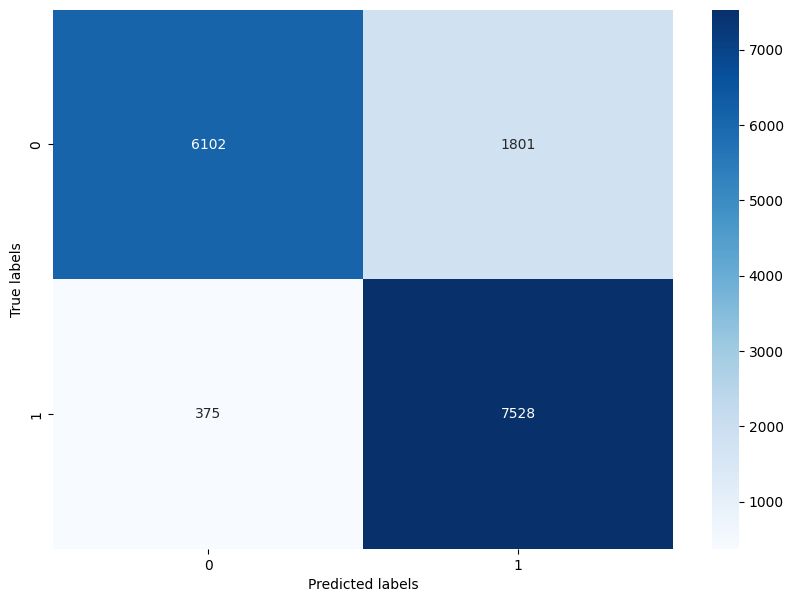

Trainer is attempting to log a value of "[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]" of type <class 'numpy.ndarray'> for key "eval/y_true" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]" of type <class 'numpy.ndarray'> for key "eval/y_pred" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [96]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_test
)

# Evaluate on the test set
results = trainer.evaluate(eval_dataset=encoded_dataset['test'])

#print(results)

In [97]:
results

{'eval_loss': 0.10050062835216522,
 'eval_f1': 0.8623307604707073,
 'eval_roc_auc': 0.8623307604707073,
 'eval_accuracy': 0.8623307604707073,
 'eval_recall': 0.8623307604707073,
 'eval_precision': 0.8623307604707073,
 'eval_f1_macro': 0.8612010129616213,
 'eval_recall_macro': 0.8623307604707073,
 'eval_precision_macro': 0.8745244537458361,
 'eval_f1_weighted': 0.8612010129616212,
 'eval_recall_weighted': 0.8623307604707073,
 'eval_precision_weighted': 0.8745244537458361,
 'eval_f1_binary': 0.8737233054781801,
 'eval_recall_binary': 0.9525496646842971,
 'eval_precision_binary': 0.8069460821095509,
 'eval_y_true': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]], dtype=float32),
 'eval_y_pred': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]]),
 'eval_runtime': 1365.0123,
 'eval_samples_per_second': 11.579,
 'eval_steps_per_second': 1.448}

C:\Users\chucki\AppData\Local\Temp\ipykernel_13636\3414195251.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


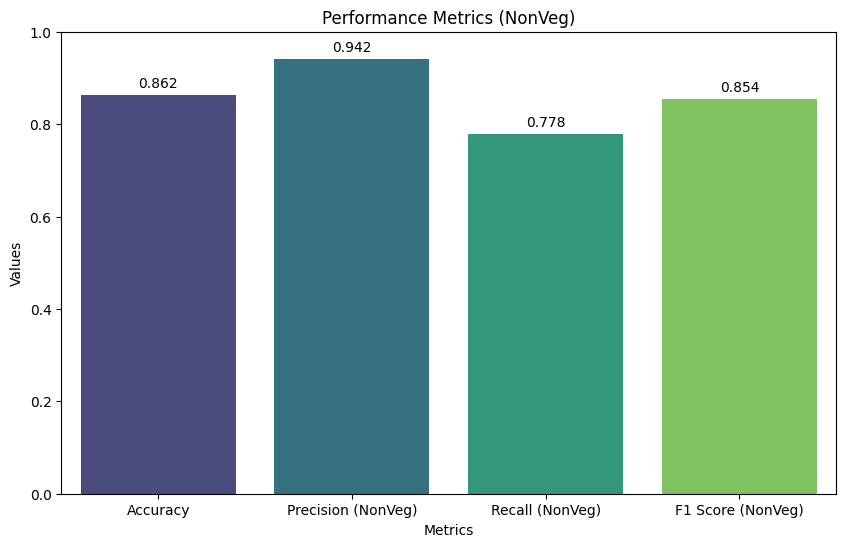

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
accuracy = 0.8623307604707073
precision = 0.942
recall = 0.778
f1_score = 0.854

# Plotting Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision (NonVeg)', 'Recall (NonVeg)', 'F1 Score (NonVeg)']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Performance Metrics (NonVeg)')
plt.ylim(0, 1)
for i in range(len(values)):
    plt.text(i, values[i] + 0.01, f'{values[i]:.3f}', ha='center', va='bottom')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()
